## Load dan Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Import Library

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


## Path Dataset

In [3]:
# Ganti path di bawah sesuai lokasi dataset kamu
data_dir = "/content/drive/MyDrive/Dicoding/Capstone/skin tone classification data"
# Cek isi folder
os.listdir(data_dir)


['White', 'Olive', 'dark brown']

In [4]:
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"Label: {folder} - Jumlah gambar: {num_images}")


Label: White - Jumlah gambar: 322
Label: Olive - Jumlah gambar: 355
Label: dark brown - Jumlah gambar: 386


## Preprocessing dan Augmentasi

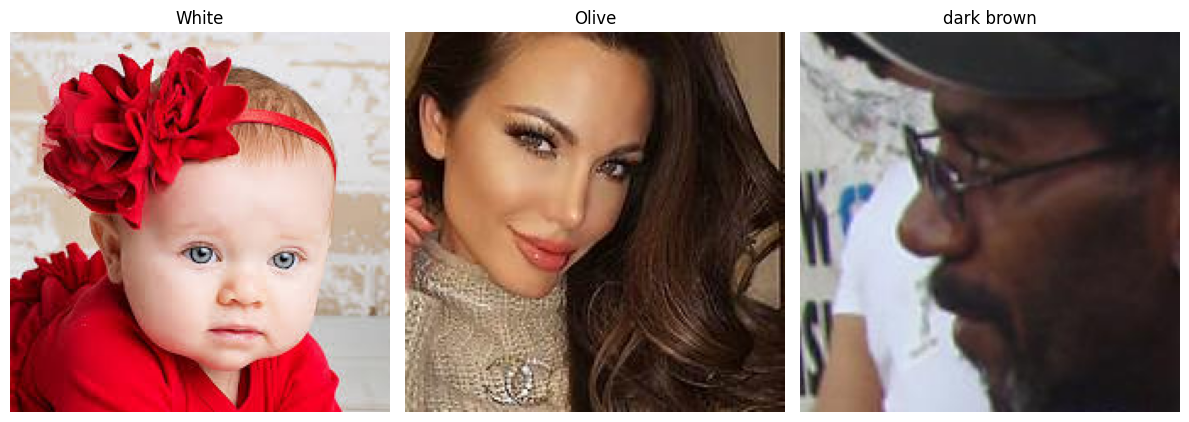

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

labels = os.listdir(data_dir)

plt.figure(figsize=(12, 6))
i = 1
for label in labels:
    folder_path = os.path.join(data_dir, label)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        if image_files:
            img_path = os.path.join(folder_path, image_files[0])
            img = Image.open(img_path)
            plt.subplot(1, len(labels), i)
            plt.imshow(img)
            plt.title(label)
            plt.axis("off")
            i += 1
plt.tight_layout()
plt.show()


In [6]:
import tensorflow as tf
import numpy as np
import random

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke folder dataset
dataset_path = data_dir

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Tetapkan seed agar pembagian data tetap konsisten
SEED = 42

# Data latih
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

# Data validasi (gunakan generator yang sama tapi subset='validation')
val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 851 images belonging to 3 classes.
Found 212 images belonging to 3 classes.


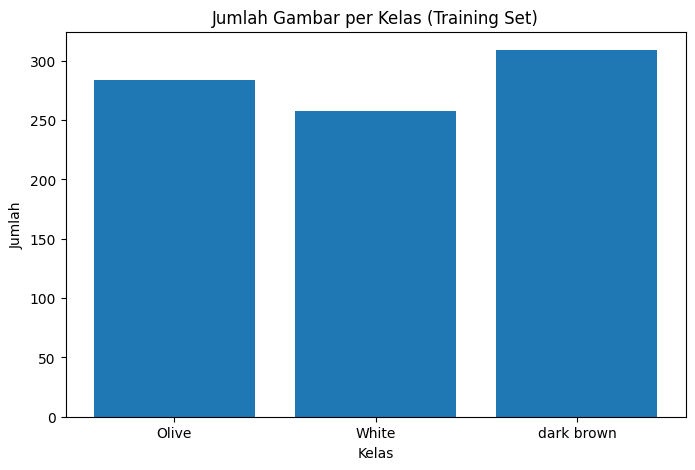

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Tampilkan jumlah gambar per kelas
class_counts = train_data.classes
class_names = list(train_data.class_indices.keys())
unique, counts = np.unique(class_counts, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(class_names, counts)
plt.title('Jumlah Gambar per Kelas (Training Set)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.show()


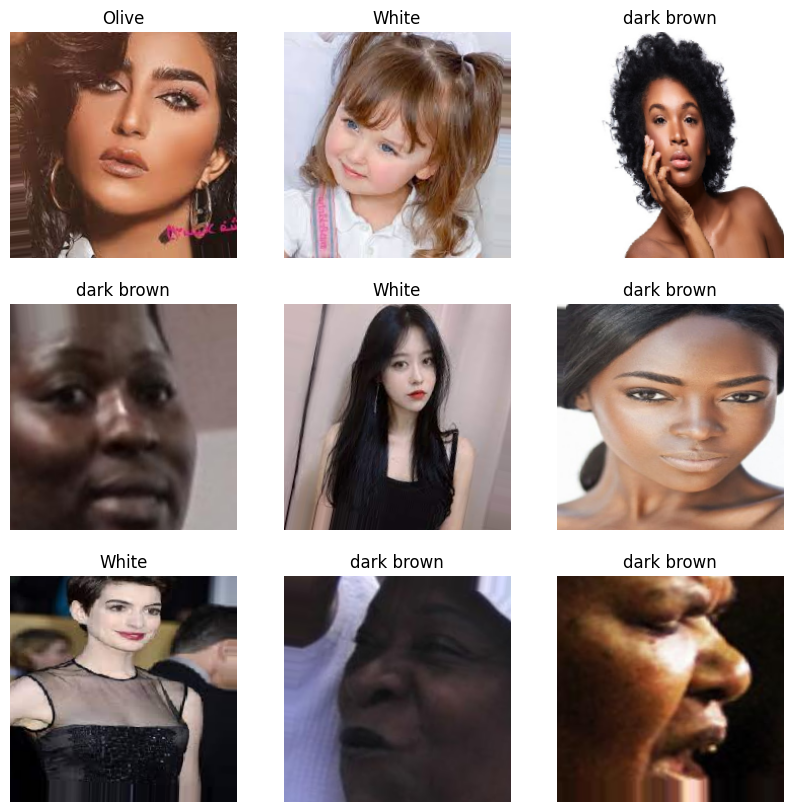

In [9]:
# Tampilkan 9 sample gambar
images, labels = next(train_data)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()


## Training Model ML Menggunakan CNN

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

cnn_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
    tf.keras.layers.BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten + Dense
    Flatten(),
    Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
cnn_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,673,123 (197.12 MB)

 Trainable params: 51,671,203 (197.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', save_best_only=True)
]

history = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7594 - loss: 0.6377 - val_accuracy: 0.3632 - val_loss: 5.6154
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 659ms/step - accuracy: 0.7812 - loss: 0.5955 - val_accuracy: 0.3632 - val_loss: 6.4317
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 698ms/step - accuracy: 0.8001 - loss: 0.5271 - val_accuracy: 0.3632 - val_loss: 9.4886
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 850ms/step - accuracy: 0.8122 - loss: 0.6264 - val_accuracy: 0.3726 - val_loss: 4.5832
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 944ms/step - accuracy: 0.8554 - loss: 0.3751 - val_accuracy: 0.6226 - val_loss: 1.6955
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 615ms/step - accuracy: 0.8053 - loss: 0.4857 - val_accuracy: 0.3868 - val_loss: 4.3066
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 659ms/step - accuracy: 0.8522 - loss: 0.3795 - val_accuracy: 0.6274 - val_loss: 1.9848
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 853ms/step - accuracy: 0.8686 - loss: 0.3752 - val_accurac

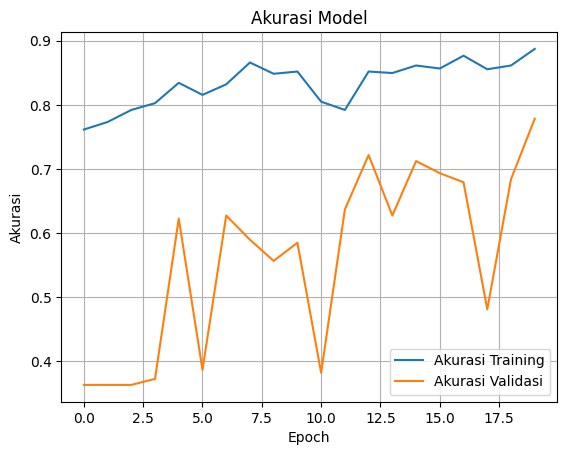

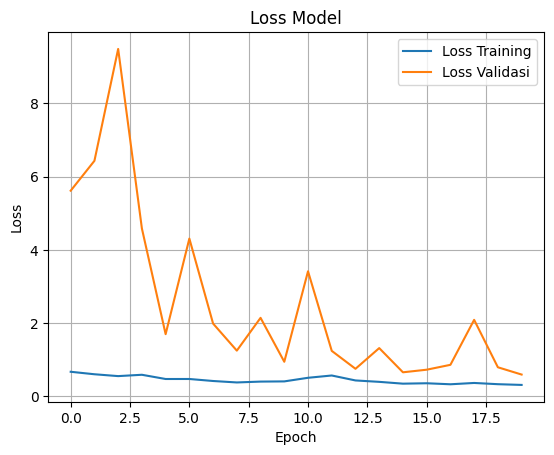

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
val_loss, val_accuracy = cnn_model.evaluate(val_data)
print(f"Akurasi Validasi: {val_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.8028 - loss: 0.5117
Akurasi Validasi: 77.36%


In [19]:
cnn_model.save('ModelCNN_skin_tone_classification.keras')

## Training Model ML Menggunakan Scikit Learn

In [21]:
# Transisi tensorflow ke scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import os

X = []
y = []

image_size = (64, 64)

for label in os.listdir(data_dir):
    folder = os.path.join(data_dir, label)
    if os.path.isdir(folder):
        for image_name in os.listdir(folder):
            if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(folder, image_name)
                try:
                    image = Image.open(image_path).convert('RGB')
                    image = image.resize(image_size)
                    image_array = np.array(image).flatten()
                    X.append(image_array)
                    y.append(label)
                except:
                  continue

X = np.array(X)
y = LabelEncoder().fit_transform(y)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Presisi:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print(classification_report(y_test, y_pred))

Akurasi: 0.8215962441314554
Presisi: 0.8216834233247586
Recall: 0.8215962441314554
F1 Score: 0.8210448190502694
              precision    recall  f1-score   support

           0       0.76      0.77      0.76        69
           1       0.84      0.78      0.81        69
           2       0.86      0.91      0.88        75

    accuracy                           0.82       213
   macro avg       0.82      0.82      0.82       213
weighted avg       0.82      0.82      0.82       213



In [23]:
import joblib
joblib.dump(rf_model, 'model_skin_tone_classification.pkl')

['model_skin_tone_classification.pkl']

## Inference Model

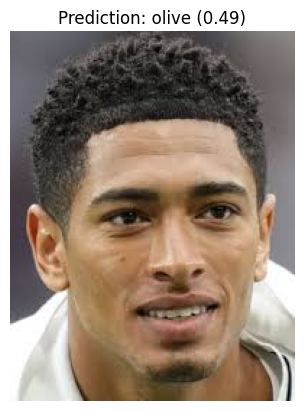

Prediction: olive
Confidence: 0.49
Class Probabilities: {'olive': 0.49, 'light': 0.33, 'dark': 0.18}


In [42]:
import joblib
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt

def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image = image.resize((64, 64))
    image_array = np.array(image).flatten()
    return image_array.reshape(1, -1)

model_path = '/content/model_skin_tone_classification.pkl'
model = joblib.load(model_path)

class_names = ['olive', 'light', 'dark']

image_path = '/content/drive/MyDrive/Dicoding/Capstone/belling.jpg'

try:
    with open(image_path, 'rb') as f:
        image_bytes = f.read()

    features = preprocess_image(image_bytes)

    probabilities = model.predict_proba(features)[0]
    prediction_index = model.predict(features)[0]
    confidence = float(np.max(probabilities))

    probability_dict = {
        class_names[i]: round(float(prob), 2)
        for i, prob in enumerate(probabilities)
    }

    original_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Prediction: {class_names[prediction_index]} ({confidence:.2f})")
    plt.show()

    print("Prediction:", class_names[prediction_index])
    print("Confidence:", round(confidence, 2))
    print("Class Probabilities:", probability_dict)

except FileNotFoundError:
    print("Error: Gambar tidak ditemukan.")
except Exception as e:
    print("Terjadi kesalahan:", e)